<a href="https://www.kaggle.com/code/animeshhalder/bcd-v1-0?scriptVersionId=112693221" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Background**

According to the WHO, breast cancer is the most commonly occurring cancer worldwide. In 2020 alone, there were 2.3 million new breast cancer diagnoses and 685,000 deaths. Regular mammograms (mammogram is the low-dose x-rays of the breast) is the process which can helps to detect breast cancer at its early stage, followed by other methodologies like ultrasounds, other imaging tests and biopsies. 
Depending on the patient's condition, the mammography test price ranges from Rs. 800 and could go up to Rs. 3000 in India. Currently, screening mammography systems are expensive to operate since early diagnosis of breast cancer necessitates the expertise of highly trained human observers. This issue will probably get worse due to an impending scarcity of radiologists in various countries. A high prevalence of false positive results is another side effect of mammography screening. This may lead to unwarranted concern, difficult follow-up care, further imaging tests, and occasionally the requirement for tissue sampling (often a needle biopsy). 

# Goal of the Competition

The objective of this challenge is to create a model to identify breast cancer from screening mammograms received from routine screening.

## Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import plotly_express as px
import pydicom as dicom
from pydicom import dcmread


## Loading the Dataset

In [2]:
Train_data = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
Test_data = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

In [3]:
Train_data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


## Data Description

| Attributes | Details | 
| --- | --- |
| site_id | ID code for the source hospital. | 
| patient_id | ID code for the patient. | 
| image_id | ID code for the image. | 
| laterality | Whether the image is of the left or right breast. | 
| view | The orientation of the image. The default for a screening exam is to capture two views per breast. | 
| age | The patient's age in years. | 
| implant | Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level. | 
| density | A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. | 
| machine_id | An ID code for the imaging device. | 
| cancer | Whether or not the breast was positive for cancer. The target value. Only provided for train. |
| biopsy | Whether or not a follow-up biopsy was performed on the breast. Only provided for train. |
| invasive | If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train. |
| BIRADS | Breast Imaging Reporting & Data System output. 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train. |
| prediction_id | The ID for the matching submission row. Multiple images will share the same prediction ID. Test only. |
| difficult_negative_case | True if the case was unusually difficult. Only provided for train. | 

## Data Inspection

In [4]:
print('Train Dataset')
print('Number of ROWs:', Train_data.shape[0], '\nNumber of COLOUMNs:', Train_data.shape[1])
print('---------------------------------------------------------------------------')
print('Test Dataset')
print('Number of ROWs:', Test_data.shape[0], '\nNumber of COLOUMNs:', Test_data.shape[1])

Train Dataset
Number of ROWs: 54706 
Number of COLOUMNs: 14
---------------------------------------------------------------------------
Test Dataset
Number of ROWs: 4 
Number of COLOUMNs: 9


In [5]:
print('Number of unique patients:',Train_data.patient_id.nunique())
print('Number of unique machine_id:',Train_data.machine_id.nunique())
# print('Average mammogram for each patient:',Train_data.groupby("patient_id")["image_id"].agg("count").reset_index()["image_id"].mean())

Number of unique patients: 11913
Number of unique machine_id: 10


In [6]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [7]:
Train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
site_id,54706.0,1.460407e+00,4.984344e-01,1.0,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
patient_id,54706.0,3.269887e+04,1.889386e+04,5.0,1.648100e+04,3.243200e+04,4.899900e+04,6.553400e+04
image_id,54706.0,1.079386e+09,6.183269e+08,68491.0,5.458153e+08,1.082689e+09,1.613228e+09,2.147472e+09
age,54669.0,5.854393e+01,1.005088e+01,26.0,5.100000e+01,5.900000e+01,6.600000e+01,8.900000e+01
cancer,54706.0,2.116770e-02,1.439444e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
biopsy,54706.0,5.427193e-02,2.265556e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
invasive,54706.0,1.495266e-02,1.213645e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
BIRADS,26286.0,7.723503e-01,5.900624e-01,0.0,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
implant,54706.0,2.699887e-02,1.620815e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
machine_id,54706.0,5.461838e+01,4.478480e+01,21.0,2.900000e+01,4.900000e+01,4.900000e+01,2.160000e+02


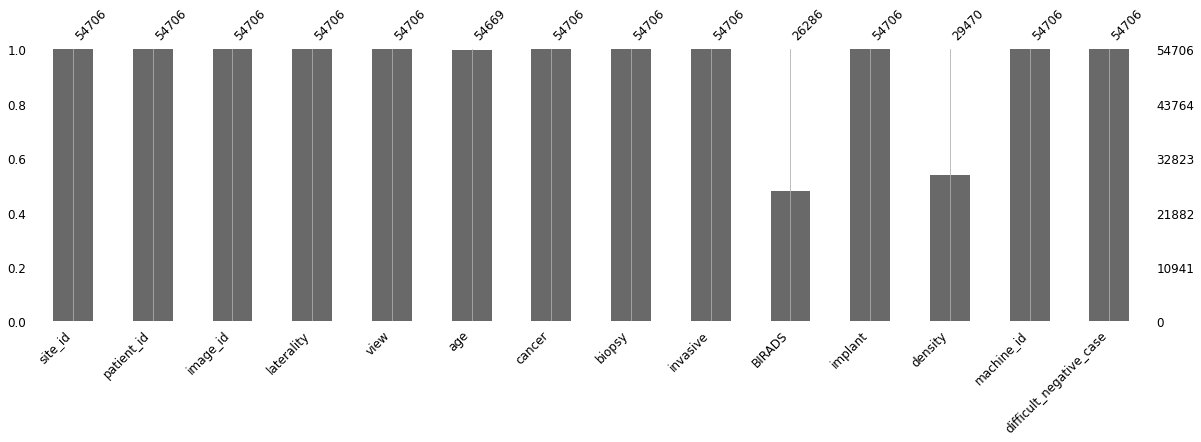

In [8]:
msno.bar(Train_data,figsize=(20, 5),fontsize=12)
plt.grid()

In [9]:
dups = Train_data.duplicated()
print('Total no of duplicate values in dataset = %d' % (dups.sum()))

Train_data[dups]

Total no of duplicate values in dataset = 0


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case


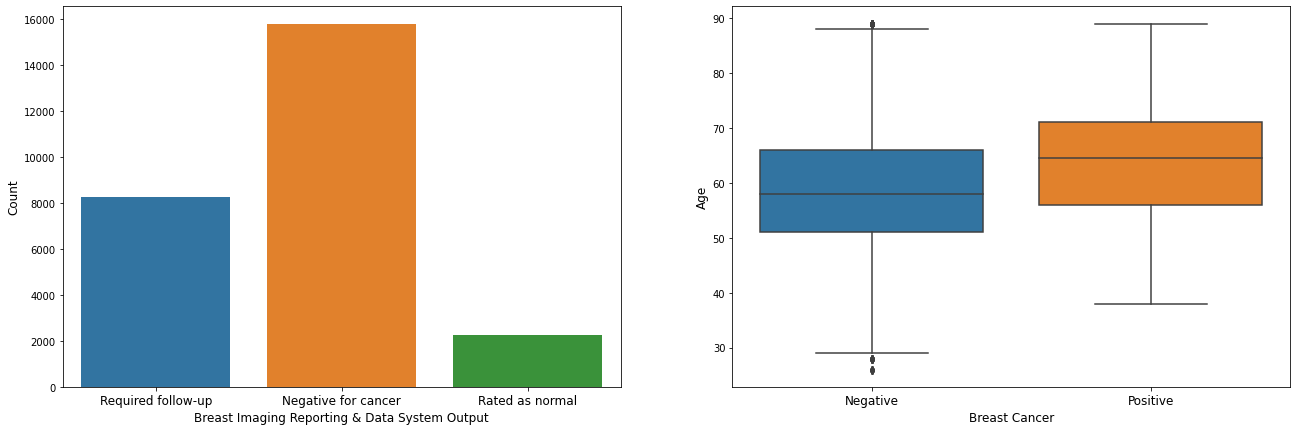

In [10]:
plt.figure(figsize = (22,7))
plt.subplot(1,2,1)
sns.countplot(x = Train_data.BIRADS)
plt.xticks(np.arange(3), ['Required follow-up', 'Negative for cancer','Rated as normal'], fontsize=12)
plt.xlabel('Breast Imaging Reporting & Data System Output', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x = Train_data.cancer, y = Train_data.age, data = Train_data) 
plt.xticks(np.arange(2), ['Negative', 'Positive'], fontsize=12)
plt.xlabel('Breast Cancer', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.show()

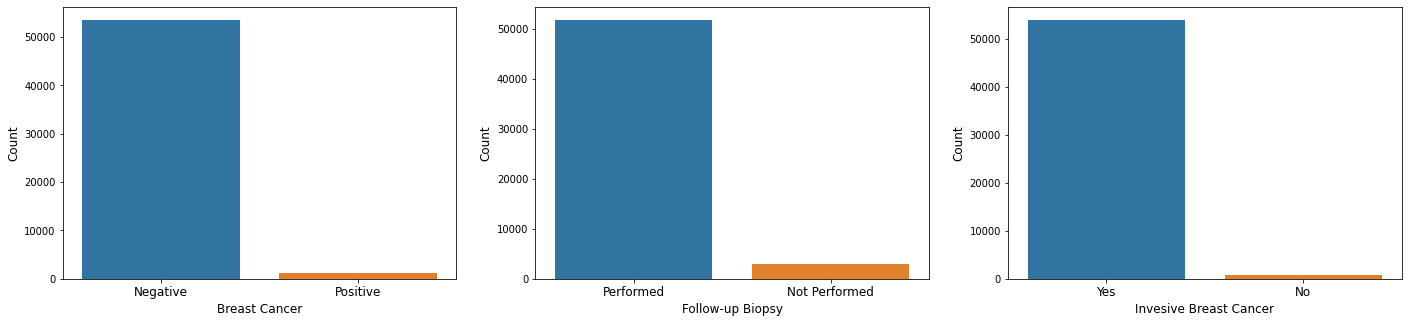

In [11]:
plt.figure(figsize = (24,5))
plt.subplot(1,3,1)
sns.countplot(x = Train_data.cancer)
plt.xticks(np.arange(2), ['Negative', 'Positive'], fontsize=12)
plt.xlabel('Breast Cancer', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.subplot(1,3,2)
sns.countplot(x = Train_data.biopsy)
plt.xticks(np.arange(2), ['Performed', 'Not Performed'], fontsize=12)
plt.xlabel('Follow-up Biopsy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.subplot(1,3,3)
sns.countplot(x = Train_data.invasive)
plt.xticks(np.arange(2), ['Yes', 'No'], fontsize=12)
plt.xlabel('Invesive Breast Cancer', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [12]:
Train_data.groupby(['cancer','implant','invasive'])['cancer'].count()

cancer  implant  invasive
0       0        0           52084
        1        0            1464
1       0        0             340
                 1             805
        1        1              13
Name: cancer, dtype: int64

Next will explore on image data